##보스턴 주택 가격 모델

In [1]:
import pandas as pd
import numpy as np
import random

from scipy.stats import norm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xg

import warnings

warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("/content/drive/MyDrive/DAT학회/실습 공부(Kaggle)/2. House Prices: Advanced Regression Techniques/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/DAT학회/실습 공부(Kaggle)/2. House Prices: Advanced Regression Techniques/test.csv")

In [3]:
print(train_data.head())
print('-' * 20)
print(train_data.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

##정말 많은 변수 (2가지 측면 고려)
1. 결측치 개수
2. categorical & numerical
-->결측치 개수에 따라 변수를 나눔

1.full: 결측치 없음
2. medium: 결측치 비율 50% 미만
3. Remove_me: 결측치 비율 50% 이상

In [4]:
full = pd.DataFrame()
medium = pd.DataFrame()
remove_me = pd.DataFrame()

features = train_data.columns.values
number_of_houses = 1460 #train_data.shape[0] 최대값 1460

for feature in features:
  if train_data[feature].count() == number_of_houses:
    full[feature] = train_data[feature]
  elif train_data[feature].count() > number_of_houses * 0.5: #값이 50%이상 있음
    medium[feature] = train_data[feature]
  else:
    remove_me[feature] = train_data[feature]

Tip)select_dtypes로 원하는 데이터 타입을 지정해서 열을 선택할 수 있다.
-숫자형식의 데이터 타입만 선택: select_dtypes(include = 'number')<br>
-object형식의 데이터 타입만 선택: se;ect_dtypes(include='object')

##Numerical & Categorical 진행
dtypes(include=["number/O"])
number: 수치 데이터
O: 문자 데이

In [5]:
print("Number of numerical features: ", end="")
print(len(train_data.select_dtypes(include=['number']).columns.values)) #숫자 열값만 가져온 것(dtypes 사용해서)
train_data.describe(exclude=['O']) #숫자 0이 아니라 문자 O
#여기서는 숫자로 되어 있는 값만 보여줌 (Numerical)

Number of numerical features: 38


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


##describe(include=["O"])를 통해 object변수의 요약통계량을 확인할 수 있다.
-count: 데이터 개수
-unique: unique한 값 개수
-top: 가장 많은 빈도수를 갖는 값
-freq: top에 해당하는 값의 빈도

In [6]:
##categorical진행
print('Number of categorical features: ', end="")
print(len(train_data.select_dtypes(include=['O']).columns.values))
train_data.describe(include=['O']) #include=["O"] Object값을 제외한 기술값 제공 -> 문자열을 제외한 모든 수치 열 줌

Number of categorical features: 43


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,...,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,...,870,605,1311,1326,1340,3,157,49,1267,1198


다음과 같은 변수들 제거
1. id 변수(의미 없음)
2. remove_me (결측치 비율 50%이상)
3. 결측치 비율이 높지는 않지만, 대부분 0의 값을 가져 큰 의미가 없는 변수

In [7]:
train_data = train_data.drop(['Id'], axis=1)

train_data = train_data.drop(remove_me.columns.values, axis=1)

#중요한 데이터 사용
numerical_data = train_data.select_dtypes(include=['number'])
categorical_data = train_data.select_dtypes(include=['object'])

#대부분의 0의 값을 가진 의미없는 변수 없애기 -> zero / 1460
feature_zero_ratio = {feature: numerical_data.loc[numerical_data[feature]==0, feature].count() / 1460 for feature in numerical_data.columns.values}
#뒤에 for ~~~전까지만 보기
#numerical_data.loc[numberical_data[feature]==0->행, feature->열]/ 즉 값이 0일때의 열만 보여줌 -> 개

feature_zero_ratio


{'MSSubClass': 0.0,
 'LotFrontage': 0.0,
 'LotArea': 0.0,
 'OverallQual': 0.0,
 'OverallCond': 0.0,
 'YearBuilt': 0.0,
 'YearRemodAdd': 0.0,
 'MasVnrArea': 0.5897260273972603,
 'BsmtFinSF1': 0.3198630136986301,
 'BsmtFinSF2': 0.8856164383561644,
 'BsmtUnfSF': 0.08082191780821918,
 'TotalBsmtSF': 0.025342465753424658,
 '1stFlrSF': 0.0,
 '2ndFlrSF': 0.5678082191780822,
 'LowQualFinSF': 0.9821917808219178,
 'GrLivArea': 0.0,
 'BsmtFullBath': 0.5863013698630137,
 'BsmtHalfBath': 0.9438356164383561,
 'FullBath': 0.0061643835616438354,
 'HalfBath': 0.6253424657534247,
 'BedroomAbvGr': 0.00410958904109589,
 'KitchenAbvGr': 0.0006849315068493151,
 'TotRmsAbvGrd': 0.0,
 'Fireplaces': 0.4726027397260274,
 'GarageYrBlt': 0.0,
 'GarageCars': 0.05547945205479452,
 'GarageArea': 0.05547945205479452,
 'WoodDeckSF': 0.5212328767123288,
 'OpenPorchSF': 0.44931506849315067,
 'EnclosedPorch': 0.8575342465753425,
 '3SsnPorch': 0.9835616438356164,
 'ScreenPorch': 0.9205479452054794,
 'PoolArea': 0.99520547

##0의 비율이 0.3을 넘는 변수들 제거

In [8]:
for feature in numerical_data: #숫자로만 이루어진 열 데이터
  if feature_zero_ratio[feature] > 0.3:
    numerical_data = numerical_data.drop([feature], axis=1) #0값이 0.3이상 버리기
    train_data = train_data.drop([feature], axis=1)
    #값을 버릴때는 numerical / train값 둘 다 버려야함
    if feature in medium: #medium 결측치 비율 50%미만
      medium = medium.drop([feature], axis=1)

##seaborn 패키지의 heatmap기능을 이용해 numerical변수들과 target간의 상관관계 확인

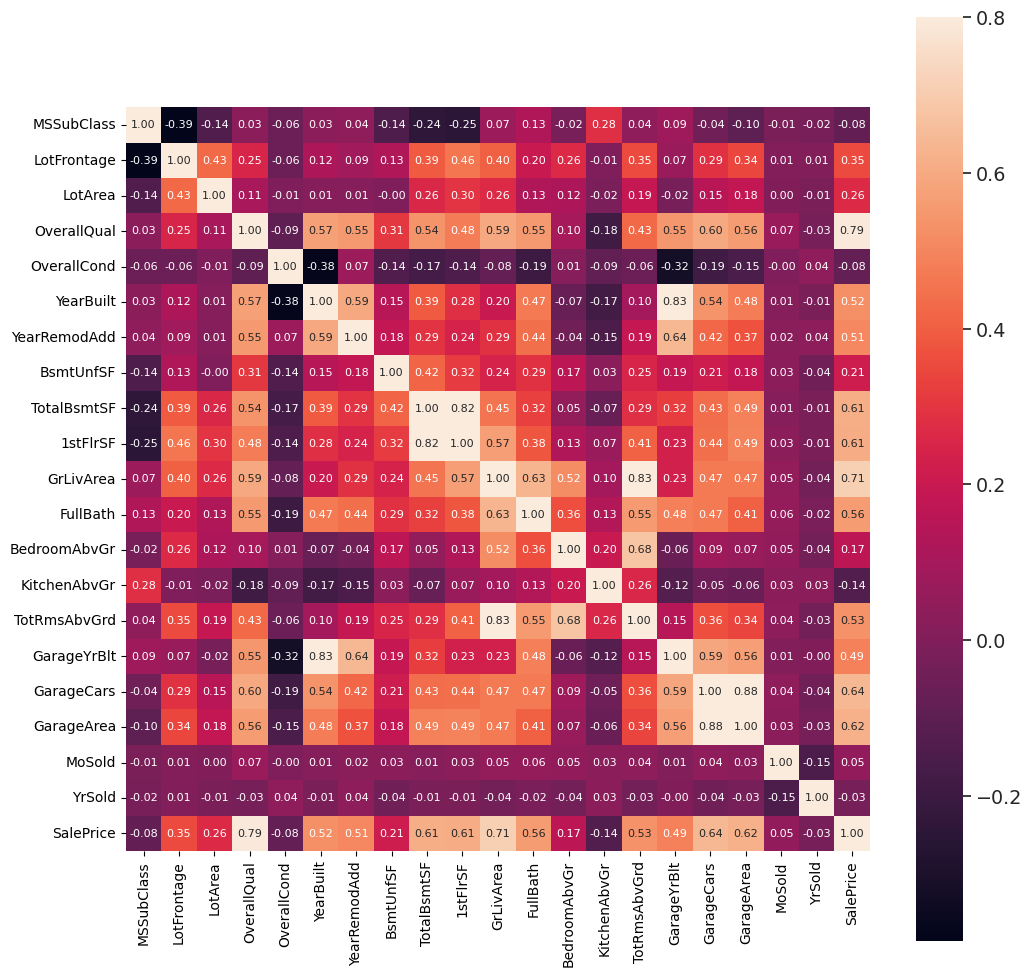

In [9]:
corrmat = numerical_data.corr() #상관관계 map
fig, ax = plt.subplots(figsize=(12,12)) #그래프 크기12,12 fig, ax는 각각 그래프의 전체 프레임과 그 안의 축 (설정)
#subplots에는 행,열 나타나 있
sns.set(font_scale=1.25) #sns는 seaborn약자 / fontscale 1.25배로 조금 더 크게
sns.heatmap(corrmat, vmax=.8, annot=True, square=True, annot_kws={'size' :8}, fmt='.2f')
#vmax는 색상의 최대 값 0.8 (0.8이상의 값들은 동일하게 나옴) / annot: 각 셀에 값을 표시 / annot_kws는 주석(셀의 값ex)0.13...)의 폰트 크기를 8 / fmt는 소수점 자리
plt.show()


##Target변수인 "SalePrice"와 상관관계가 높은 상위 10개 변수들로만 다시 heatmap그리기
TIP) pandas.DataFrame.nlargest(n, columns) = df.sort_values(columns, ascending=False).head(n)

['SalePrice' 'OverallQual' 'GrLivArea' 'GarageCars' 'GarageArea'
 'TotalBsmtSF' '1stFlrSF' 'FullBath' 'TotRmsAbvGrd' 'YearBuilt']


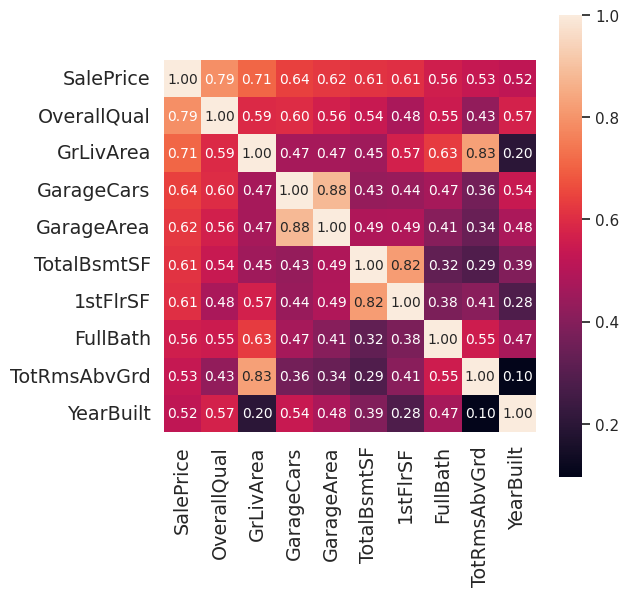

In [10]:
n = 10
most_largest_features = corrmat.nlargest(n, 'SalePrice')['SalePrice'].index #가장 관계가 높은 상관관계 10개만 고른거 (INDEX 가져옴(순서))
zoomed_corrmat = np.corrcoef(numerical_data[most_largest_features].values.T) #T -> 배열의 행과열을 바꾸는 방법
#np.coeecoef는 각 "행"간의 상관계수를 계산. 하지만 우리가 원하는 것은 "컬럼"간의 상관계수
#행 -> 관측치 / 열 -> 특징 --> 우리는 관측치의 관계보다 특징의 관계를 원함
fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1)
sns.heatmap(zoomed_corrmat, annot=True, square=True, fmt='.2f', annot_kws={'size' : 10}, yticklabels=most_largest_features.values, xticklabels=most_largest_features.values)
#ticklabel은 y, x축 결정 -> 상위 n개의 특징의 이름을 numpy배열로 반환. 이 이름들이 x,y축 이름으로 나옴
print(most_largest_features.values)

##Target변수와 상관관계가 높은 상위 7개의 변수들의 관계를 scatter plot으로 살펴본다

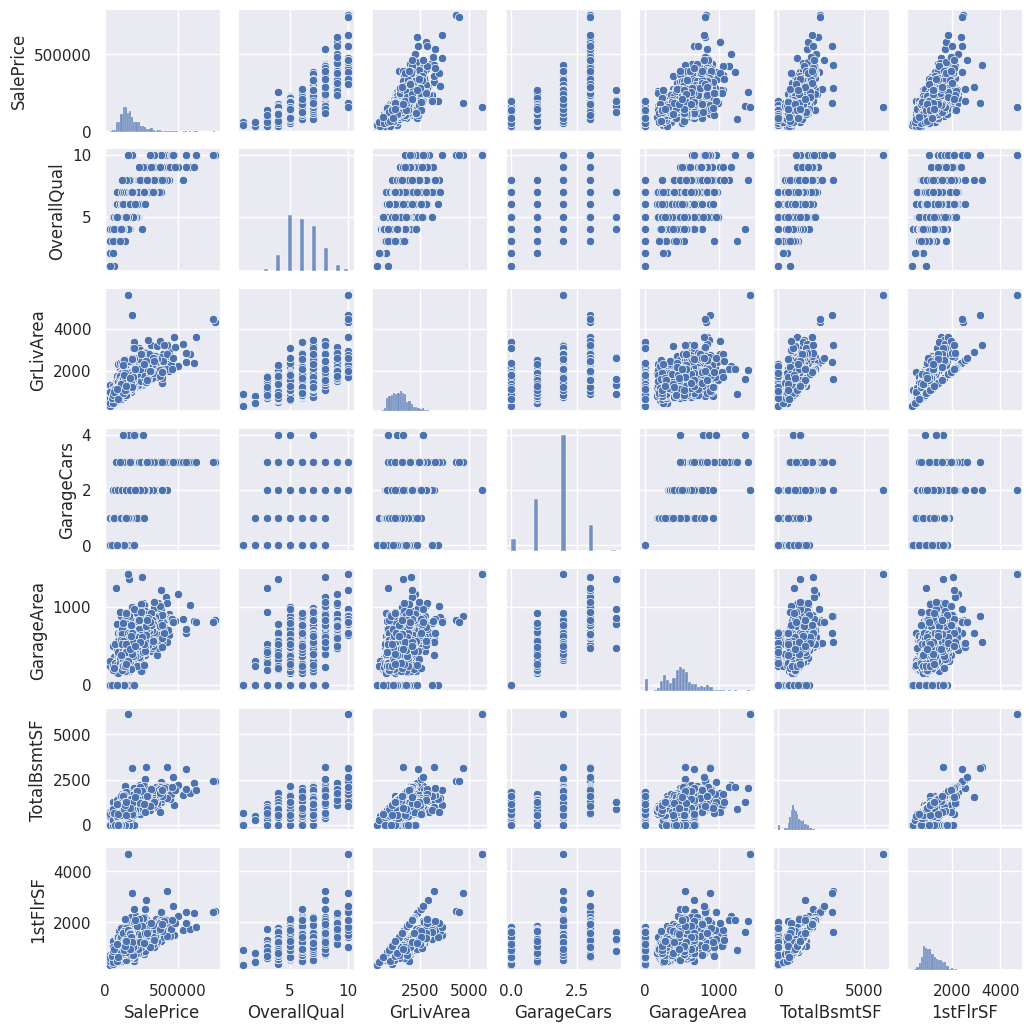

In [11]:
sns.set()
most_largest_features = corrmat.nlargest(7, 'SalePrice')['SalePrice'].index
#most_largest_features = corrmat.nlargest(7, 'SalePrice') 여기까지가 상관계수가 가장 큰 상위 7개의 행. 그 행이 salePrice 컬럼만 선
sns.pairplot(numerical_data[most_largest_features.values], size=1.5)
plt.show()

##선형관계가 존재하는 변수들 중 Target변수와 상관관계가 더 높은 변수를 남기고 낮은 변수는 제거
salesprice와 비교해봤을 때, 선형석이없고 타겟 데이터와 상관관계가 낮아보이면 없앰

##정확히 GarageYrBlt를 왜 없애는지는 모르겠음

In [12]:
numerical_data = numerical_data.drop(['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt'],axis=1)
train_data = train_data.drop(['1stFlrSF', 'TotalBsmtSF', 'GarageArea', 'GarageYrBlt'],axis=1)

##Target변수와의 상관관계가 [-0.1, 0.2] 사이인 "nutural"변수 제거


In [13]:
corr_with_price = numerical_data.corr()
corr_with_price = corr_with_price.sort_values(by='SalePrice', ascending=False)
corr_with_price['SalePrice']

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
LotFrontage     0.351799
LotArea         0.263843
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
MoSold          0.046432
YrSold         -0.028923
OverallCond    -0.077856
MSSubClass     -0.084284
KitchenAbvGr   -0.135907
Name: SalePrice, dtype: float64

In [14]:
numerical_data = numerical_data.drop(['MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'BedroomAbvGr'],axis=1)
train_data = train_data.drop(['MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'BedroomAbvGr'],axis=1)

##결측치 처리
numerical 변수 -> median, mean / mean-std to mean + std 사이의 random value로 대체<br>
categorical 변수 -> 최빈값으로 대체 / 다른 분석


##numerical 변수 결측치 확인

In [15]:
numerical_data.info()
#LotFrontage가 결측

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   LotArea       1460 non-null   int64  
 2   OverallQual   1460 non-null   int64  
 3   YearBuilt     1460 non-null   int64  
 4   YearRemodAdd  1460 non-null   int64  
 5   BsmtUnfSF     1460 non-null   int64  
 6   GrLivArea     1460 non-null   int64  
 7   FullBath      1460 non-null   int64  
 8   KitchenAbvGr  1460 non-null   int64  
 9   TotRmsAbvGrd  1460 non-null   int64  
 10  GarageCars    1460 non-null   int64  
 11  SalePrice     1460 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 137.0 KB


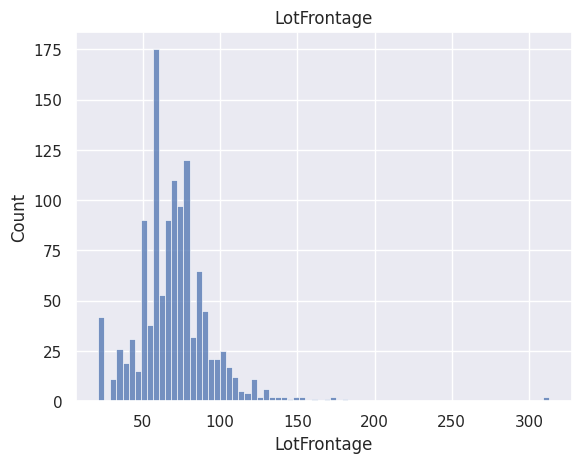

In [16]:
sns.histplot(numerical_data['LotFrontage'])#histplot 데이터의 분포를 히스토그램 형태로 시각
plt.title('LotFrontage')
plt.show()

In [17]:
old_LotFrontage = list(numerical_data['LotFrontage'].values) #LotFrontage컬럼의 모든 값 리스트 형태로 저장
missing_indices = list(numerical_data.loc[numerical_data['LotFrontage'].isnull(), 'LotFrontage'].index) #LotFrontage의 결측치 있는 행, lotFrontage 열의 인덱스 알려주기
random_values = [random.randint(60,80) for _ in range(1460 - numerical_data['LotFrontage'].count())] #60~80사이의 결측값만들기. 전체1460-데이터 = 결측치 데이터
#즉, 결측치 데이터만큼 60~80 랜덤값만듬
random_values_idx = 0

for missing_idx in missing_indices: #결측치 있는 인덱스에서 하나씩 가져오면서
  old_LotFrontage[missing_idx] = random_values[random_values_idx] #그에 맞는 인덱스에 아까 60~80으로 만든 랜덤값 넣기
  random_values_idx += 1 #새로만든 random_values의 인덱스에 새로운 값을 넣어야해서 +1씩 추

  numerical_data['LotFrontage'] = pd.Series(old_LotFrontage) #pd.series는 padnas 라이브러리에서 제공하는 1차원 배열 형태의 자료구
  train_data['LotFrontage'] = pd.Series(old_LotFrontage)

In [18]:
categorical_data.info()
#결측치가 매우 많은 FireplaceQu 변수는 삭제
#나머지 변수들에 대해서는 Simplemputer를 활용해 최빈값을 결측치 대체

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1460 non-null   object
 1   Street         1460 non-null   object
 2   LotShape       1460 non-null   object
 3   LandContour    1460 non-null   object
 4   Utilities      1460 non-null   object
 5   LotConfig      1460 non-null   object
 6   LandSlope      1460 non-null   object
 7   Neighborhood   1460 non-null   object
 8   Condition1     1460 non-null   object
 9   Condition2     1460 non-null   object
 10  BldgType       1460 non-null   object
 11  HouseStyle     1460 non-null   object
 12  RoofStyle      1460 non-null   object
 13  RoofMatl       1460 non-null   object
 14  Exterior1st    1460 non-null   object
 15  Exterior2nd    1460 non-null   object
 16  MasVnrType     1452 non-null   object
 17  ExterQual      1460 non-null   object
 18  ExterCond      1460 non-null

In [19]:
train_data.info(), categorical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSZoning       1460 non-null   object 
 1   LotFrontage    1460 non-null   float64
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  YearBuilt      1460 non-null   int64  
 16  YearRemodAdd   1460 non-null   int64  
 17  RoofStyle      1460 non-null   object 
 18  RoofMatl

(None, None)

In [20]:
train_data = train_data.drop(['FireplaceQu'], axis=1)
categorical_data = categorical_data.drop(['FireplaceQu'], axis=1)

imputer -> sklearn에 포함이며 결측치 대체 방법을 제공
###strategy에서는 mean, median, most_frequent, constant(사용자 지정) 값 넣을 수 있음

##reshape(-1, 1)은 해당 배열을 2차원 배열로 변환
ex) [1,2,3,4,5] --> <br>
[1<br>
                    2<br>
                    3<br>
                    4<br>
                    5]<br>
여기서 -1은 해당 차원의 크기가 "자동으로 결정되어야 함"을 의미
                  

In [21]:
imputer = SimpleImputer(missing_values=np.NaN, strategy="most_frequent")
#결측치가 어떻게 이루어져있는지? -> NaN, 그 결측치를 자주나오는 값으로 넣어주
for feature in categorical_data:
  categorical_data[feature] = imputer.fit_transform(categorical_data[feature].values.reshape((-1,1)))
  train_data[feature] = imputer.fit_transform(train_data[feature].values.reshape((-1,1)))



Outliers 처리

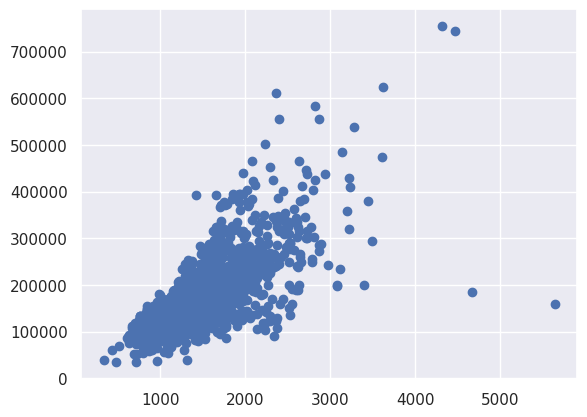

In [22]:
plt.scatter(train_data['GrLivArea'], train_data['SalePrice'])
plt.show()
#lot도 이상치가 있는데, 여기서는 왜 GrLivArea만 하지?


In [23]:
train_data[ (train_data['GrLivArea'] > 4000) & train_data['SalePrice'] < 200000].index #값이 조금 다르게 나온 것 같기도

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459],
           dtype='int64', length=1460)

In [24]:
train_data['id'] = pd.Series(train_data.index)
train_data = train_data.drop(train_data[(train_data['id'] ==1298) | (train_data['id'] == 523)].index)
#다시 확실하게 지우기
train_data = train_data.drop(['id'], axis=1)

In [25]:
train_data = pd.get_dummies(train_data)#범주형 변수를 원-핫 코딩 형태로 변환

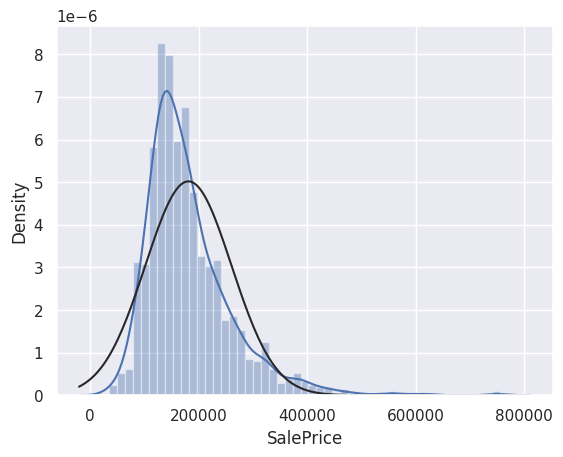

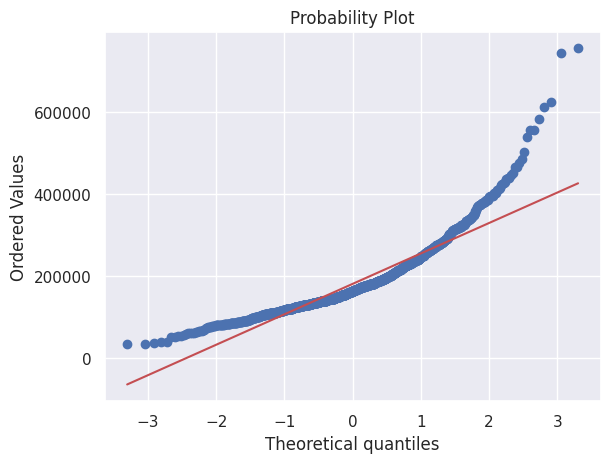

In [26]:
sns.distplot(train_data['SalePrice'], fit=norm) #fit=norm은 데이터의 분포와 정규분포를 함께 표시 (분포가 얼마나 정규 분포와 유사한지 시각적으로 평가)
fig = plt.figure() #그림 객체 생성
res = stats.probplot(train_data['SalePrice'], plot = plt) #probplot은 표본 데이터의 분포와 비

##정규분포를 따르지 않는 것 같아서 로그화 진행
1. 왜도 감소: 데이터가 오른쪽으로 길게 늘어진 긴 꼬리 분포를 가질 때(즉, 왜도가 양수일 때), 로그 변환은 그 긴 꼬리를 줄이고 분포를 좀 더 대칭적으로 만들 수 있습니다.

2. 분산의 안정화: 로그 변환은 데이터의 분산을 안정화하는 효과가 있습니다. 일부 데이터셋에서는 몇몇 값들이 너무 크거나 작아서 분산이 큰 경우가 있는데, 로그 변환을 통해 이러한 문제를 완화할 수 있습니다.

3. 곱셈/나눗셈을 덧셈/뺄셈으로 변환: 로그 변환은 곱셈이나 나눗셈 연산을 덧셈이나 뺄셈 연산으로 바꾸는 효과가 있습니다. 이는 로그의 수학적 특성 때문입니다.

4. 왜곡된 분포를 다룰 때 유용: 로그 변환은 회귀와 같은 통계적 모델링에서 종속 변수나 예측 변수가 심하게 왜곡된 분포를 가질 때 유용하게 사용됩니다.

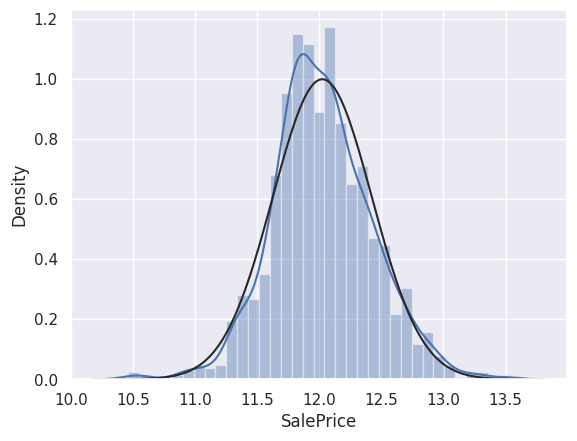

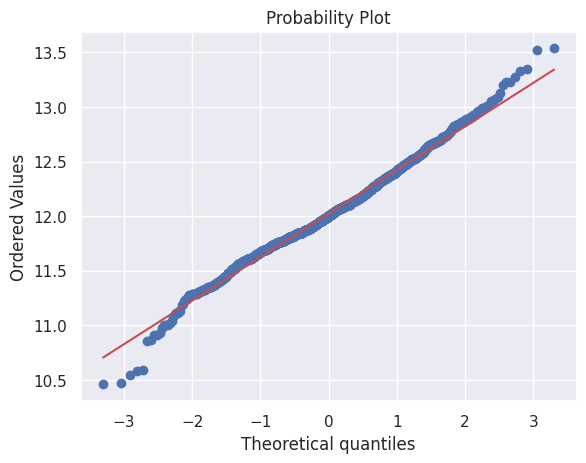

In [27]:
train_data['SalePrice'] = np.log(train_data['SalePrice'])
sns.distplot(train_data['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(train_data['SalePrice'], plot=plt)

In [29]:
target = train_data['SalePrice'] #결과값
train_data = train_data.drop(['SalePrice'], axis=1) #train_data에 결과값 없앰
#값 분리해서 편하게 주기
X,y = train_data, target



##LinearRegression

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X,y)
pred = lin_reg.predict(X) #X예측값
print(lin_reg.score(X,y)) #정확도
np.sqrt(mean_squared_log_error(pred,y)) #에러
#sqrt -> Root Mean Squared Logarithmic Error: 실제 값과 예측 값의 로그 차이의 제곱 평균의 제곱근

0.9361215314214824


0.007866548903982789

##RandomForestRegressor

In [34]:
forest_reg = RandomForestRegressor()
forest_reg.fit(X,y)
pred = forest_reg.predict(X)
print(forest_reg.score(X,y))
np.sqrt(mean_squared_log_error(pred, y))

0.9819596430238319


0.0041918224059684026

##xGBRegressor

In [37]:
xg_reg = xg.XGBRegressor(objective= 'reg:linear',
                         n_estimators = 300, seed = 123)
xg_reg.fit(X,y)
pred = xg_reg.predict(X)
print(xg_reg.score(X,y))
np.sqrt(mean_squared_log_error(pred, y))

[11:47:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0.9999786520737325


0.0001425500090568103

In [44]:
len(pred)

1458

In [42]:
test_data['Id']

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64